In [1]:
import tensorflow as tf
import os
import sys
from importlib import reload
import gdal

sys.path.insert(0, '../src')
import deepgeo.dataset.utils as dsutils 
import deepgeo.utils.geofunctions as gf
import deepgeo.networks.model_builder as mb
import deepgeo.dataset.preprocessor as prep
import deepgeo.dataset.sequencialchips as seqchips
import deepgeo.utils.visualization as vis

reload(dsutils)
reload(gf)
reload(mb)
reload(prep)
reload(seqchips)

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'deepleeo.dataset.sequencialchips' from '../src/deepleeo/dataset/sequencialchips.py'>

In [2]:
network = "fcn1s"
DATA_DIR = "/home/raian/doutorado/Dados/generated"
trained_model = os.path.join(DATA_DIR, 'tf_logs', 'test_fcn1s_09_01_2019-23_12_20/')
raster_path = os.path.join(DATA_DIR, 'stacked_mosaic_2016_2017.tif')
output_path = os.path.join(DATA_DIR, "prediction_%s.tiff" % (network))

In [3]:
params = {
    "epochs": 2,
    "batch_size": 200,
    "learning_rate": 0.0001,
    "l2_reg_rate": 0.5,
    "var_scale_factor": 2.0,
    "chips_tensorboard": 4,
    "dropout_rate": 0.5,
    "class_names": ["not_deforestation", "deforestation"],
    "multi_gpu": False #TODO: Review this
}

In [4]:
preproc = prep.Preprocessor(raster_path, no_data=-9999)
raster_array = preproc.standardize_image()
chips = seqchips.generate_sequential_chips(raster_array, chip_size=286)#, overlap=(93, 93))

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


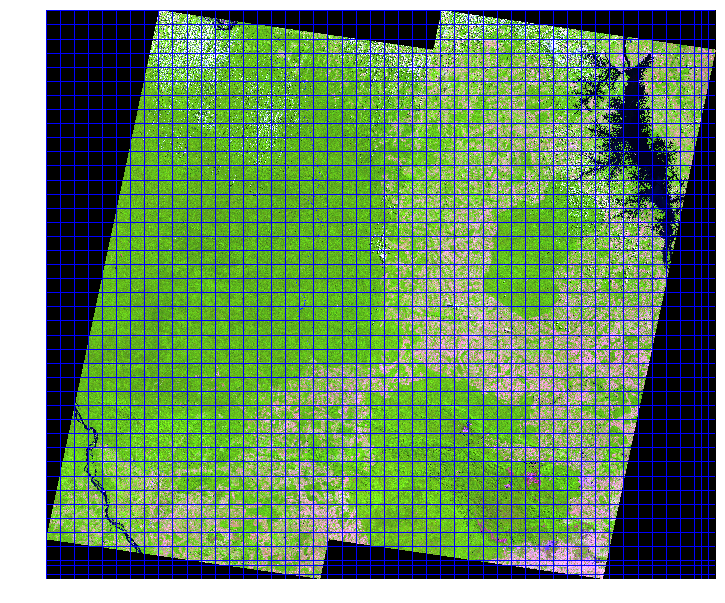

In [5]:
original_raster = gf.load_image(raster_path, 0)
seqchips.plot_chips(chips, original_raster, bands=[3, 2, 1], contrast=True)

In [6]:
reload(mb)
model = mb.ModelBuilder(network)
predictions = model.predict(chips["chips"], params=params, model_dir=trained_model)
out_pred = chips.copy()
out_pred["chips"] = predictions.copy()

Classifying image with structure  (1968, 286, 286, 10) ...
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/raian/doutorado/Dados/generated/tf_logs/test_fcn1s_09_01_2019-23_12_20/model.ckpt-147000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [7]:
seqchips.write_chips(output_path, raster_path, out_pred)

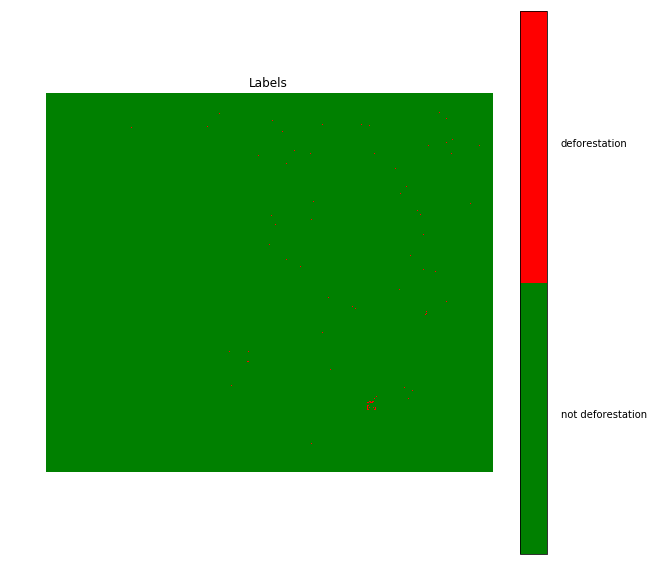

In [8]:
new_ds = gdal.Open(output_path)
rarr = new_ds.ReadAsArray()
vis.plot_labels(rarr, ["not deforestation", "deforestation"], colors=["green", "red"])